In [1]:
import os.path as osp
import numpy as np
import numpy.linalg as npla
np.set_printoptions(6, suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'font.size': 7,
})

import utils

def rpy2rot(y, p, r):
    roll = lambda r: np.array([[1, 0, 0], [0, np.cos(r), np.sin(r)], [0, -np.sin(r), np.cos(r)]], dtype=np.float64)
    pitch = lambda p: np.array([[np.cos(p), 0, -np.sin(p)], [0, 1, 0], [np.sin(p), 0, np.cos(p)]], dtype=np.float64)
    yaw = lambda y: np.array([[np.cos(y), np.sin(y), 0], [-np.sin(y), np.cos(y), 0], [0, 0, 1]], dtype=np.float64)
    return roll(r) @ pitch(p) @ yaw(y)


def convert_line_to_pose(line):
    # returns T_iv
    line = line.replace('\n', ',').split(',')
    line = [float(i) for i in line[:-1]]
    # x, y, z -> 1, 2, 3
    # roll, pitch, yaw -> 7, 8, 9
    T = np.eye(4, dtype=np.float64)
    T[0, 3] = line[1]  # x
    T[1, 3] = line[2]  # y
    T[2, 3] = line[3]  # z
    T[:3, :3] = rpy2rot(line[9], line[8], line[7])

    return T


def load_pred_poses(filename):
    data = np.loadtxt(filename)
    poses = []
    for v in data:
        T_ms = np.eye(4)
        T_ms[:3, :] = v.reshape(3, 4)
        poses.append(T_ms)
    return np.array(poses)


def load_gt_poses(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    poses = []
    for line in lines[1:]:
        pose = convert_line_to_pose(line)
        poses.append(pose)

    T_s0_m = npla.inv(poses[0])
    poses = [T_s0_m @ T_ms for T_ms in poses]
    return np.array(poses)


def plot_pred_poses(ax, pred_poses, gt_poses, label, color, xlim=None, ylim=None):
    # T_gt_pred = utils.align_path(gt_poses, pred_poses)
    T_gt_pred = gt_poses[0] @ npla.inv(pred_poses[0])
    pred_poses = T_gt_pred @ pred_poses
    ax.plot(pred_poses[:, 0, 3] / 1e3, pred_poses[:, 1, 3] / 1e3, label=label, linewidth=1.0, color=color)
    max_x = np.max(pred_poses[:, 0, 3] / 1e3)
    min_x = np.min(pred_poses[:, 0, 3] / 1e3)
    max_y = np.max(pred_poses[:, 1, 3] / 1e3)
    min_y = np.min(pred_poses[:, 1, 3] / 1e3)
    mid_x = (max_x + min_x) / 2
    mid_y = (max_y + min_y) / 2
    range_x = max_x - min_x
    range_y = max_y - min_y
    longer = max(range_x, range_y)
    longer *= 1.1

    interval = 1
    left = ((mid_x - longer / 2) // interval) * interval
    right = ((mid_x + longer / 2) // interval + 1) * interval
    top = ((mid_y + longer / 2) // interval + 1) * interval
    bottom = ((mid_y - longer / 2) // interval) * interval
    ax.xaxis.set_ticks(np.arange(left, right, interval))
    ax.yaxis.set_ticks(np.arange(bottom, top, interval))

    if xlim is None:
        ax.set_xlim(mid_x - longer / 2, mid_x + longer / 2)
    else:
        ax.set_xlim(*xlim)
    if ylim is None:
        ax.set_ylim(mid_y - longer / 2, mid_y + longer / 2)
    else:
        ax.set_ylim(*ylim)


gt_path = '/home/yuchen/ASRL/steam_icp/data/aeva/'
pred_path = '/home/yuchen/ASRL/steam_icp/src/results/aeva_long/'

In [2]:
### compute trajectory distance
sequences = [
    '04',  # Ontario Highway 7
    '05',  # Ontario Highway 404
    '06',  # Don Valley Parkway
    '07',  # Ontario Highway 427
]

for sequence in sequences:
  print(f"{sequence}:")
  gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'applanix/aeva_poses.csv'))
  distance = utils.trajectory_distances(gt_poses)[-1]
  print(f"  distance: {distance}")

04:
  distance: 8875.75365264618
05:
  distance: 7836.395261738037
06:
  distance: 10309.714431294382
07:
  distance: 7238.412029265754


In [3]:
### compute kitti metric
sequences = [
    '04',  # Ontario Highway 7
    '05',  # Ontario Highway 404
    '06',  # Don Valley Parkway
    '07',  # Ontario Highway 427
]
methods = ["doppler_icp", "elastic_icp", "steam_icp", "steam_dicp"]
load_gt_fn = lambda sequence: load_gt_poses(osp.join(gt_path, sequence, 'applanix/aeva_poses.csv'))[60:]
load_pred_fn = lambda sequence, pred_file: load_pred_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
utils.print_results(sequences, methods, load_gt_fn, load_pred_fn)


doppler_icp
  04   05   06   07 
elastic_icp
  04   05   06   07 
steam_icp
  04   05   06   07 
steam_dicp
  04   05   06   07 
kitti metric t_err_2d
doppler_icp  & 2.87 & 1.03 & 0.68 & 1.97  & 1.74
elastic_icp  & 0.41 & 0.36 & 0.50 & 0.45  & 0.43
steam_icp  & 0.46 & 0.32 & 0.45 & 0.37  & 0.41
steam_dicp  & 0.40 & 0.46 & 0.37 & 0.39  & 0.40

kitti metric t_err_3d
doppler_icp  & 5.63 & 3.95 & 3.20 & 4.11  & 4.34
elastic_icp  & 2.81 & 3.03 & 2.48 & 2.08  & 2.63
steam_icp  & 2.84 & 3.02 & 2.44 & 2.09  & 2.63
steam_dicp  & 2.82 & 3.08 & 2.41 & 2.09  & 2.63

kitti metric r_err_2d
doppler_icp  & 0.0067 & 0.0027 & 0.0017 & 0.0020  & 0.0036
elastic_icp  & 0.0007 & 0.0008 & 0.0010 & 0.0012  & 0.0009
steam_icp  & 0.0008 & 0.0006 & 0.0008 & 0.0008  & 0.0008
steam_dicp  & 0.0005 & 0.0012 & 0.0006 & 0.0008  & 0.0007

kitti metric r_err_3d
doppler_icp  & 0.0137 & 0.0123 & 0.0142 & 0.0097  & 0.0127
elastic_icp  & 0.0058 & 0.0054 & 0.0118 & 0.0072  & 0.0076
steam_icp  & 0.0058 & 0.0054 & 0.0117 & 0.

In [7]:
### compute kitti metric
sequences = [
    '04',  # Ontario Highway 7
    '05',  # Ontario Highway 404
    '06',  # Don Valley Parkway
    '07',  # Ontario Highway 427
]
methods = ["doppler_icp_40m", "elastic_icp_40m", "steam_icp_40m", "steam_dicp_40m"]
load_gt_fn = lambda sequence: load_gt_poses(osp.join(gt_path, sequence, 'applanix/aeva_poses.csv'))[60:]
load_pred_fn = lambda sequence, pred_file: load_pred_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
utils.print_results(sequences, methods, load_gt_fn, load_pred_fn)


doppler_icp_40m
  04   05   06   07 
elastic_icp_40m
  04   05   06   07 
steam_icp_40m
  04   05   06   07 
steam_dicp_40m
  04   05   06   07 
kitti metric t_err_2d
doppler_icp_40m  & 13.04 & 4.49 & 1.89 & 6.49  & 7.05
elastic_icp_40m  & 10.60 & 53.17 & 57.67 & 5.29  & 30.75
steam_icp_40m  & 67.38 & 2.93 & 1.91 & 3.33  & 24.06
steam_dicp_40m  & 1.82 & 1.92 & 0.86 & 0.63  & 1.36

kitti metric t_err_3d
doppler_icp_40m  & 14.66 & 7.58 & 3.87 & 7.82  & 9.01
elastic_icp_40m  & 12.24 & 56.98 & 67.06 & 5.98  & 34.65
steam_icp_40m  & 68.30 & 5.23 & 3.64 & 4.80  & 25.59
steam_dicp_40m  & 3.92 & 4.98 & 3.23 & 3.04  & 3.80

kitti metric r_err_2d
doppler_icp_40m  & 0.0317 & 0.0120 & 0.0052 & 0.0087  & 0.0161
elastic_icp_40m  & 0.0306 & 0.0497 & 0.0910 & 0.0160  & 0.0473
steam_icp_40m  & 0.1215 & 0.0070 & 0.0050 & 0.0047  & 0.0439
steam_dicp_40m  & 0.0047 & 0.0054 & 0.0023 & 0.0015  & 0.0036

kitti metric r_err_3d
doppler_icp_40m  & 0.0366 & 0.0243 & 0.0172 & 0.0146  & 0.0246
elastic_icp_40m  & 

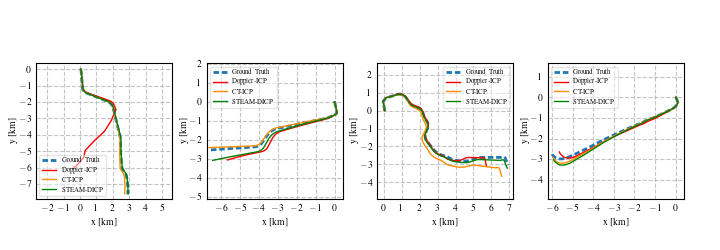

In [5]:
sequences = [
    '04',  # Ontario Highway 7
    '05',  # Ontario Highway 404
    '06',  # Don Valley Parkway
    '07',  # Ontario Highway 427
]

fig, axs = plt.subplots(1, len(sequences), figsize=(7.2, 2.5))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.0, top=0.95, wspace=0.25, hspace=0.25)

for i, sequence in enumerate(sequences):
  ax = axs[i]

  gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'applanix/aeva_poses.csv'))[60:]
  ax.plot(gt_poses[:, 0, 3] / 1e3, gt_poses[:, 1, 3] / 1e3, "--", label='Ground Truth', linewidth=2.0, dashes=(2, 1))

  pred_file = 'doppler_icp'
  pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
  plot_pred_poses(ax, pred_poses, gt_poses, 'Doppler-ICP', 'red')

  pred_file = 'elastic_icp'
  pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
  plot_pred_poses(ax, pred_poses, gt_poses, r'CT-ICP', 'darkorange')

  pred_file = 'steam_dicp'
  pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
  plot_pred_poses(ax, pred_poses, gt_poses, 'STEAM-DICP', 'green')

  ax.set_xlabel('x [km]')
  ax.set_ylabel('y [km]', labelpad=1)
  ax.grid(which='both', linestyle='--', alpha=0.75)
  ax.set_aspect('equal', 'box')
  ax.legend(framealpha=0.5, fontsize=5)
  ax.tick_params(axis=u'both', which=u'both', length=0)

# plt.savefig('/home/yuchen/ASRL/notes/2023-icra-wu/figs/boreas_qualitative.pdf', format="pdf", bbox_inches="tight")
# plt.savefig('/home/yuchen/ASRL/steam_icp/full_range.pdf', format="pdf", bbox_inches="tight")
plt.show()

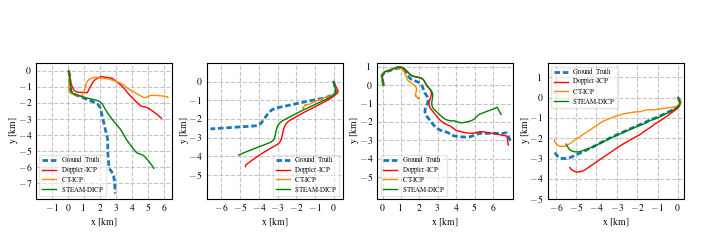

In [6]:
sequences = [
    '04',  # Ontario Highway 7
    '05',  # Ontario Highway 404
    '06',  # Don Valley Parkway
    '07',  # Ontario Highway 427
]

fig, axs = plt.subplots(1, len(sequences), figsize=(7.2, 2.5))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.0, top=0.95, wspace=0.25, hspace=0.25)

xlims = [(-2.0, 6.5), (-6.8, 0.5), (-0.3, 7.1), (-6.4, 0.3)]
ylims = [(-8.0, 0.5), (-6.3, 1.0), (-6.2, 1.2), (-5.0, 1.7)]

for i, sequence in enumerate(sequences):
  ax = axs[i]

  gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'applanix/aeva_poses.csv'))[60:]
  ax.plot(gt_poses[:, 0, 3] / 1e3, gt_poses[:, 1, 3] / 1e3, "--", label='Ground Truth', linewidth=2.0, dashes=(2, 1))

  pred_file = 'doppler_icp_40m'
  pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
  plot_pred_poses(ax, pred_poses, gt_poses, 'Doppler-ICP', 'red', xlims[i], ylims[i])

  pred_file = 'elastic_icp_40m'
  pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
  plot_pred_poses(ax, pred_poses, gt_poses, r'CT-ICP', 'darkorange', xlims[i], ylims[i])

  pred_file = 'steam_dicp_40m'
  pred_poses = load_pred_poses(osp.join(pred_path, pred_file, sequence + '_poses.txt'))[60:]
  plot_pred_poses(ax, pred_poses, gt_poses, 'STEAM-DICP', 'green', xlims[i], ylims[i])

  ax.set_xlabel('x [km]')
  ax.set_ylabel('y [km]', labelpad=1)
  ax.grid(which='both', linestyle='--', alpha=0.75)
  ax.set_aspect('equal', 'box')
  ax.legend(framealpha=0.5, fontsize=5)
  ax.tick_params(axis=u'both', which=u'both', length=0)

# plt.savefig('/home/yuchen/ASRL/notes/2023-icra-wu/figs/boreas_qualitative.pdf', format="pdf", bbox_inches="tight")
# plt.savefig('/home/yuchen/ASRL/steam_icp/40m.pdf', format="pdf", bbox_inches="tight")
plt.show()